In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

MEMORY = 20*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

2023-02-01 20:32:58.775506: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 20:32:59.007711: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-01 20:32:59.730286: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /end/home/rh2310/lib:/end/soft/Linux_2.6_64/lib::/end/home/rh2310/.conda/envs/tensorflo

1 Physical GPUs, 1 Logical GPUs


In [2]:
from local_utils import *

In [3]:
sim_names = ["Koch_Meinhardt_1", "Koch_Meinhardt_2", "Koch_Meinhardt_3",
             "Koch_Meinhardt_4", "Koch_Meinhardt_5",
             "Koch_Meinhardt_6", "Koch_Meinhardt_7", "Koch_Meinhardt_9"]
sim_name = sim_names[2]
x_slice=slice(0,99,1)#slice(30,65,1)#slice(50,65,1)#
y_slice=slice(0,99,1)#slice(50,85,1)#slice(70,85,1)#
pattern = load(sim_name, x_slice, y_slice,
               data_time_start=-300,
               data_time_len=60,
               data_time_step=5)

In [4]:
class NN_Field(tu.NN_base):
    def __init__(self, x_range, y_range, depth, dim_2d, layer_num, dtype=tf.float32, **kwargs):
        """A dense Neural Net that is specified by layers argument.

        layers: input, dense layers and outputs dimensions
        lb    : An array of minimums of inputs (lower bounds)
        ub    : An array of maximums of inputs (upper bounds)
        """
        super().__init__(dtype, **kwargs)
        self.depth = depth
        self.layer_num = layer_num
        self.dim_2d = dim_2d
        x = tf.constant(x_range, dtype=dtype)
        y = tf.constant(y_range, dtype=dtype)
        #Y,X = tf.meshgrid(x, y, indexing='ij')
        #X, Y = tf.meshgrid(x, y)
        Y, X = tf.meshgrid(x, y)
        self.X = X
        self.Y = Y
        self.domain_shape = X.shape
        self.build()
        
    def make_variables(self, k, initializer):
        return tf.Variable(initializer(shape=k, dtype=self.dtype))
    
                           
    def build(self):
        """Create the state of the layers (weights)"""
        weights = []
        scales = []
        biases = []
        
        rnd_init = tf.random_normal_initializer(stddev=1/6)
        W = tf.Variable(self.make_variables([self.depth, 3], rnd_init)
                        , dtype=self.dtype)
        #b = tf.Variable(tf.zeros([128, self.dim_2d[0], self.dim_2d[1]], dtype=self.dtype), dtype=self.dtype)
        a = tf.Variable(tf.ones([1, 1, 1, self.depth], dtype=self.dtype), dtype=self.dtype)
        b = tf.Variable(tf.zeros([1, 1, 1, self.depth], dtype=self.dtype), dtype=self.dtype)
        
        weights.append(W)
        scales.append(a)
        biases.append(b)
        for i in range(self.layer_num-1):
            rnd_init = tf.random_normal_initializer(stddev=1/(2*self.depth))
            W = tf.Variable(self.make_variables([self.depth, self.depth], rnd_init)
                        , dtype=self.dtype)
            #b = tf.Variable(tf.zeros([128, self.dim_2d[0], self.dim_2d[1]], dtype=self.dtype), dtype=self.dtype)
            a = tf.Variable(tf.ones([1, 1, self.depth], dtype=self.dtype), dtype=self.dtype)
            b = tf.Variable(tf.zeros([1, 1, self.depth], dtype=self.dtype), dtype=self.dtype)
        
            weights.append(W)
            scales.append(a)
            biases.append(b)
            
        rnd_init = tf.random_normal_initializer(stddev=1/4)
        W = tf.Variable(self.make_variables([2, self.depth], rnd_init)
                        , dtype=self.dtype)
        #b = tf.Variable(tf.zeros([2, self.dim_2d[0], self.dim_2d[1]], dtype=self.dtype), dtype=self.dtype)
        a = tf.Variable(tf.ones([1, 1, 2], dtype=self.dtype), dtype=self.dtype)
        b = tf.Variable(tf.zeros([1, 1, 2], dtype=self.dtype), dtype=self.dtype)
        
        weights.append(W)
        scales.append(a)
        biases.append(b)

        self.Ws = weights
        self.scales = scales
        self.bs = biases

    def make_inputs(self, ts):
        T = ts[tf.newaxis, tf.newaxis, :] * tf.ones(self.X.shape)[:, :, tf.newaxis]       
        return T
        
    @tf.function
    def net(self, T):
        #T = tf.fill(self.domain_shape, t)
#         H = tf.concat([tf.expand_dims(self.X, 0), 
#                        tf.expand_dims(self.Y, 0), 
#                        tf.expand_dims(T, 0)], axis=0)
    

    
         
        
        #T = ts[tf.newaxis, tf.newaxis, :] * tf.ones(self.X.shape)[:, :, tf.newaxis]
        #print(T)
        # H will be a tensor (batches, m, n, 3)
        # where batches is the len of ts,
        #       m,n are the width and hieght of the domain
        #       and 3 is for x,y,t
        H = tf.concat([tf.concat([self.X[tf.newaxis, :, :, tf.newaxis], 
                                 self.Y[tf.newaxis, :, :, tf.newaxis],
                                 T[:, :, i:i+1][tf.newaxis, :, :, :]], axis=3) for i in range(T.shape[-1])], axis=0)
        #print(H)
        def act(x):
            return x*tf.sigmoid(x)
        
        for W, a, b in zip(self.Ws, self.scales, self.bs):
            #print(W)
            mul_outputs = tf.tensordot(H, W, axes=[[-1], [-1]])
            #print(mul_outputs)
            outputs =  a * mul_outputs + b
            #outputs =  mul_outputs + b
            #print(outputs)
            #H = tf.tanh(outputs)
            #H = tf.sigmoid(outputs)
            H = act(outputs)
            #print(H)

        return outputs
    
    @tf.function
    def net2(self, t):                
        T = tf.fill(self.domain_shape, t)
        
        H = tf.concat([tf.expand_dims(self.X, 0), 
                       tf.expand_dims(self.Y, 0), 
                       tf.expand_dims(T, 0)], axis=0)
        
        for W, a, b in zip(self.Ws, self.scales, self.bs):
            mul_outputs = tf.tensordot(W, H, axes=[[0], [0]])
            #print(mul_outputs)
            outputs =  a * mul_outputs + b
            #print(outputs)
            H = tf.tanh(outputs)
            #print(H)

        return outputs

    def gradients(self, inputs, outputs):
        """finds the first and second order griadients of outputs at inputs

        Args:
           inputs: A tensor that has a shape [None, D1], where
                   D1 is the input dimensionality, specified in
                   the first element of layes.
           outputs:  A tensor that has a shape [None, Dn], where
                   Dn is the output dimensionality, specified in
                   the last element of layes.

        Return:   The returns 'partial_1' and 'partial_2' are the first and second
                  order gradients, repsectivly. Each one is a list that its elements
                  corresponds to one of the NN's last layer output. e.g. if the last layer
                  has Dn outputs, each list has Dn tensors as an elements. The dimensionality
                  of the tensors are the same as inputs: [None, D1]

        """
        partials_1 = [tf.gradients(outputs[:, i], inputs)[0] for i in range(outputs.shape[1])]
        partials_2 = [tf.gradients(partials_1[i], inputs)[0] for i in range(outputs.shape[1])]
        return partials_1, partials_2



In [ ]:
#@tf.function
def grads(pinn, ts):
    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(pinn.X)
        tape.watch(pinn.Y)        
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(pinn.X)
            tape2.watch(pinn.Y)
            T = pinn.make_inputs(ts)
            tape2.watch(T)     
            
            outputs = pinn.net(T)
        
            u = outputs[:, :, :, 0]
            v = outputs[:, :, :, 1]
            
        u_x = tape2.gradient(u, pinn.X)
        u_y = tape2.gradient(u, pinn.Y)
        u_t = tape2.gradient(u, T)
        v_x = tape2.gradient(v, pinn.X)
        v_y = tape2.gradient(v, pinn.Y)
        v_t = tape2.gradient(v, T)
            
    u_xx = tape.gradient(u_x, pinn.X)
    u_xy = tape.gradient(u_x, pinn.Y)
    u_yx = tape.gradient(u_y, pinn.X)
    u_yy = tape.gradient(u_y, pinn.Y)
    v_xx = tape.gradient(v_x, pinn.X)
    v_yy = tape.gradient(v_y, pinn.Y)
    v_xy = tape.gradient(v_x, pinn.Y)
    v_yx = tape.gradient(v_y, pinn.X)
    #return (u, u_xx, u_yy, u_t, v, v_xx, v_yy, v_t)
    return (tf.squeeze(u),
            tf.squeeze(u_xx), tf.squeeze(u_yy), tf.squeeze(u_xy), tf.squeeze(u_yx), tf.squeeze(u_t),
            tf.squeeze(v),
            tf.squeeze(v_xx), tf.squeeze(v_yy), tf.squeeze(v_xy), tf.squeeze(v_yx), tf.squeeze(v_t))


In [6]:
def gen_series():    
    for i,t in enumerate(pattern.t_star):
        yield t, pattern.c[..., i]
        
ds = tf.data.Dataset.from_generator(gen_series,
                                    output_types=(tf.float32, tf.float32), 
                                    output_shapes=((), pattern.c.shape[:-1]))

In [7]:
pattern.t_star.shape

(12,)

In [10]:
optimizer2=keras.optimizers.Adam(learning_rate=2e-4)
pinn2 = NN_Field(x_range, y_range, 
                depth=32, 
                dim_2d=(pattern.block_x, pattern.block_x), 
                layer_num = 6,
                dtype=tf.float32)
norm_l2 = L2()

init_per = 2.0
D_u = tf.constant(pattern.params["D_u"], pinn.dtype, name="D_u")#tf.Variable(pattern.params["D_u"]*init_per, pinn.dtype)
D_v = tf.constant(pattern.params["D_v"], pinn.dtype, name="D_v")#tf.Variable(pattern.params["D_v"]*init_per, pinn.dtype)
def clip_by_value_zero_lb(z):
    return tf.clip_by_value(z, 0, 1e10,)

sigma_u = tf.Variable(pattern.params["sigma_u"]*init_per,
                      pinn.dtype,
                      name="sigma_u",
                      constraint=clip_by_value_zero_lb)


sigma_v = tf.Variable(pattern.params["sigma_v"]*init_per,
                      pinn.dtype,
                      name="sigma_v",
                      constraint=clip_by_value_zero_lb)

mu_u = tf.Variable(pattern.params["mu_u"]*init_per,
                   pinn.dtype,
                   name="mu_u",
                   constraint=clip_by_value_zero_lb)

rho_u = tf.Variable(pattern.params["rho_u"]*init_per,
                    pinn.dtype,
                    name="rho_u",
                    constraint=clip_by_value_zero_lb)

rho_v = tf.Variable(pattern.params["rho_v"]*init_per,
                    pinn.dtype,
                    name="rho_v",
                    constraint=clip_by_value_zero_lb)

kappa_u = tf.Variable(pattern.params["kappa_u"]*init_per,
                      pinn.dtype,
                      name="kappa_u",
                      constraint=clip_by_value_zero_lb)


params_tf = (sigma_u, sigma_v, mu_u, rho_u, rho_v, kappa_u,)

@tf.function
def train_step_inverse(elements):
    with tf.GradientTape(persistent=True) as tape: 
        tape.watch(pinn2.X)
        tape.watch(pinn2.Y)
        #tape.watch(t)
        trainables = pinn2.trainable_variables
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(pinn2.X)
            tape2.watch(pinn2.Y)
            T = pinn2.make_inputs(elements[0])
            #tape2.watch(T)
            
            outputs = pinn2.net(T)            
            u = outputs[:, :, :, 0]
            v = outputs[:, :, :, 1]
            
            u_x = tape2.gradient(u, pinn2.X)
            u_y = tape2.gradient(u, pinn2.Y)
            #u_t = tape2.gradient(u, T)
            #u_t = tf.einsum("ijt -> tij", u_t)
            
            v_x = tape2.gradient(v, pinn2.X)
            v_y = tape2.gradient(v, pinn2.Y)
            #v_t = tape2.gradient(v, T)
            #v_t = tf.einsum("ijt -> tij", v_t)
            
        
        u_xx = tape.gradient(u_x, pinn2.X)
        #u_xy = tape.gradient(u_x, pinn.Y)
        #u_yx = tape.gradient(u_y, pinn.X)
        u_yy = tape.gradient(u_y, pinn2.Y)
        v_xx = tape.gradient(v_x, pinn2.X)
        v_yy = tape.gradient(v_y, pinn2.Y)
        #v_xy = tape.gradient(v_x, pinn.Y)
        #v_yx = tape.gradient(v_y, pinn.X)
        #print(u_xx)
        #partials_2 = [tf.gradients(partials_1[i], inputs)[0] for i in range(outputs.shape[1])]
               
        f = u * u * v / (1.0 + kappa_u * u * u)
        f_u = D_u * (u_xx + u_yy) + rho_u * f - mu_u * u + sigma_u# - u_t
        f_v = D_v * (v_xx + v_yy) - rho_v * f + sigma_v# - v_t
        
        #print(u.shape)
        #print(u_xx.shape)
        #u_xyyx_diff = u_xy - u_yx
        #v_xyyx_diff = v_xy - v_yx

        #diff = outputs - elements[1] 
        #print(elements[1].shape)
        u_diff = u - elements[1][:, 0, :, :]
        v_diff = v - elements[1][:, 1, :, :]
        l2_u_obs = tf.reduce_sum(u_diff**2)
        l2_v_obs = tf.reduce_sum(v_diff**2)


        l2_res_u = tf.reduce_sum(f_u**2)
        l2_res_v = tf.reduce_sum(f_v**2)
        
        #l2_res_u_xyyx = tf.reduce_sum(u_xyyx_diff**2)
        #l2_res_v_xyyx = tf.reduce_sum(v_xyyx_diff**2)
        
        l2 = l2_u_obs + l2_v_obs + l2_res_u + l2_res_v #+ l2_res_u_xyyx + l2_res_v_xyyx
        
       
    grads = tape.gradient(l2, trainables + params_tf)
    optimizer2.apply_gradients(zip(grads, trainables + params_tf))
    return (l2_u_obs, l2_v_obs, l2_res_u, l2_res_v)#, l2_res_u_xyyx, l2_res_v_xyyx)


In [11]:
def print_callback(printer, losses, epoch):
    printer(f"at epoch {epoch:d}\n"
            f" total loss: {np.sum(losses)}"
            f" u: {losses[0]}, v: {losses[1]},\n"
            f" Res u: {losses[2]}, Res v: {losses[3]} \n")
    printer(#f"D_u: {D_u.numpy()}, D_v: {D_v.numpy()} \n"
            f"rho_u: {rho_u.numpy()}, rho_v: {rho_v.numpy()} \n"
            f"sigma_u: {sigma_u.numpy()}, sigma_v: {sigma_v.numpy()} \n"
            f"kappa_u: {kappa_u.numpy()}, mu_u: {mu_u.numpy()} \n")
            #f" Res u xyyx: {losses[4]}, Res v xyyx: {losses[5]}")
losses = tu.train(epochs=50000+1,
                  batch_size=1,
                  dataset = ds ,
                  train_step = train_step_inverse,
                  print_interval=500,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback,
                  epoch_callback=None)


Start of epoch 0


2023-02-01 20:34:19.555158: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f6aac03fb30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-01 20:34:19.555252: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-02-01 20:34:19.565214: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-01 20:34:20.019072: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


at epoch 0
 total loss: 56731.5234375 u: 7859.85546875, v: 9424.201171875,
 Res u: 329.72003173828125, Res v: 39117.74609375 

rho_u: 1.9984263181686401, rho_v: 2.5017082691192627 
sigma_u: 0.19760873913764954, sigma_v: 1.9975996017456055 
kappa_u: 0.0, mu_u: 2.002246856689453 

Time taken: 17.50s

Start of epoch 500
at epoch 500
 total loss: 54.010040283203125 u: 41.69462585449219, v: 11.377250671386719,
 Res u: 0.16084061563014984, Res v: 0.7773241400718689 

rho_u: 1.9963188171386719, rho_v: 2.5149357318878174 
sigma_u: 0.21848005056381226, sigma_v: 1.9762628078460693 
kappa_u: 0.018941828981041908, mu_u: 1.9878231287002563 

Time taken: 171.18s

Start of epoch 1000
at epoch 1000
 total loss: 53.911190032958984 u: 41.72453308105469, v: 11.382415771484375,
 Res u: 0.16606301069259644, Res v: 0.6381813287734985 

rho_u: 1.991919755935669, rho_v: 2.5144612789154053 
sigma_u: 0.22946776449680328, sigma_v: 1.9620656967163086 
kappa_u: 0.030870679765939713, mu_u: 1.9820314645767212 

Time


Start of epoch 12000
at epoch 12000
 total loss: 7.349606037139893 u: 4.942447185516357, v: 0.9453291296958923,
 Res u: 0.34867098927497864, Res v: 1.1131587028503418 

rho_u: 2.219561815261841, rho_v: 2.3469040393829346 
sigma_u: 9.124612552113831e-05, sigma_v: 1.6715480089187622 
kappa_u: 0.15223731100559235, mu_u: 1.7552818059921265 

Time taken: 235.53s

Start of epoch 12500
at epoch 12500
 total loss: 6.920467376708984 u: 4.379617214202881, v: 0.9938006401062012,
 Res u: 0.40425869822502136, Res v: 1.1427907943725586 

rho_u: 2.2250916957855225, rho_v: 2.3407294750213623 
sigma_u: 2.1069199647172354e-05, sigma_v: 1.6577941179275513 
kappa_u: 0.1598827838897705, mu_u: 1.749862551689148 

Time taken: 234.99s

Start of epoch 13000
at epoch 13000
 total loss: 6.209012031555176 u: 3.9228017330169678, v: 0.833707869052887,
 Res u: 0.3541938066482544, Res v: 1.0983086824417114 

rho_u: 2.2302541732788086, rho_v: 2.333329916000366 
sigma_u: 0.00013650217442773283, sigma_v: 1.644374370574

at epoch 23500
 total loss: 1.9759390354156494 u: 0.6473574638366699, v: 0.28154441714286804,
 Res u: 0.4754091501235962, Res v: 0.5716279745101929 

rho_u: 2.2785656452178955, rho_v: 2.149136781692505 
sigma_u: 9.001029684441164e-05, sigma_v: 1.4362305402755737 
kappa_u: 0.24137820303440094, mu_u: 1.692578911781311 

Time taken: 239.35s

Start of epoch 24000
at epoch 24000
 total loss: 2.468587875366211 u: 1.1950311660766602, v: 0.23817916214466095,
 Res u: 0.24373045563697815, Res v: 0.79164719581604 

rho_u: 2.279510974884033, rho_v: 2.1411564350128174 
sigma_u: 1.7970122598853777e-06, sigma_v: 1.4292131662368774 
kappa_u: 0.2430873066186905, mu_u: 1.690921664237976 

Time taken: 238.31s

Start of epoch 24500
at epoch 24500
 total loss: 1.465151309967041 u: 0.49862903356552124, v: 0.16157187521457672,
 Res u: 0.4495207965373993, Res v: 0.35542958974838257 

rho_u: 2.279910087585449, rho_v: 2.1328186988830566 
sigma_u: 0.0, sigma_v: 1.422890305519104 
kappa_u: 0.2438722550868988, mu_


Start of epoch 35000
at epoch 35000
 total loss: 2.032489061355591 u: 0.8280083537101746, v: 0.3094441294670105,
 Res u: 0.3233047127723694, Res v: 0.5717318654060364 

rho_u: 2.2795698642730713, rho_v: 1.9727610349655151 
sigma_u: 0.00033142909524030983, sigma_v: 1.3171077966690063 
kappa_u: 0.24227508902549744, mu_u: 1.6920310258865356 

Time taken: 238.07s

Start of epoch 35500
at epoch 35500
 total loss: 1.1979457139968872 u: 0.6006554961204529, v: 0.16072410345077515,
 Res u: 0.17960117757320404, Res v: 0.25696495175361633 

rho_u: 2.2795538902282715, rho_v: 1.9665260314941406 
sigma_u: 0.0002689614484552294, sigma_v: 1.3133838176727295 
kappa_u: 0.24269598722457886, mu_u: 1.6916446685791016 

Time taken: 237.92s

Start of epoch 36000
at epoch 36000
 total loss: 0.7241561412811279 u: 0.3047647476196289, v: 0.07401878386735916,
 Res u: 0.14393018186092377, Res v: 0.2014423906803131 

rho_u: 2.2793498039245605, rho_v: 1.9608231782913208 
sigma_u: 0.0, sigma_v: 1.309397578239441 
ka


Start of epoch 46500
at epoch 46500
 total loss: 0.32952001690864563 u: 0.1005101203918457, v: 0.03684018552303314,
 Res u: 0.1412992775440216, Res v: 0.050870444625616074 

rho_u: 2.267897129058838, rho_v: 1.8630112409591675 
sigma_u: 0.0005198902799747884, sigma_v: 1.2391068935394287 
kappa_u: 0.24925245344638824, mu_u: 1.6767630577087402 

Time taken: 237.68s

Start of epoch 47000
at epoch 47000
 total loss: 0.48665130138397217 u: 0.13822782039642334, v: 0.08968999981880188,
 Res u: 0.12805432081222534, Res v: 0.1306791603565216 

rho_u: 2.2676596641540527, rho_v: 1.8610785007476807 
sigma_u: 0.0003191257710568607, sigma_v: 1.2371270656585693 
kappa_u: 0.2491927444934845, mu_u: 1.6755311489105225 

Time taken: 238.25s

Start of epoch 47500
at epoch 47500
 total loss: 1.2950999736785889 u: 0.2870364189147949, v: 0.08863868564367294,
 Res u: 0.45070353150367737, Res v: 0.46872133016586304 

rho_u: 2.2663660049438477, rho_v: 1.8581533432006836 
sigma_u: 2.842100730049424e-05, sigma_v:

In [22]:
optimizer2.lr

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0002>

In [23]:
optimizer.lr.assign(8e-5)
losses_2 = tu.train(epochs=20000+1,
                  batch_size=1,
                  dataset = ds ,
                  train_step = train_step_inverse,
                  print_interval=500,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback,
                  epoch_callback=None)


Start of epoch 0
at epoch 0
 total loss: 0.5497100353240967 u: 0.24098387360572815, v: 0.07663115859031677,
 Res u: 0.11092957854270935, Res v: 0.12116540968418121 

rho_u: 2.2629988193511963, rho_v: 1.84751558303833 
sigma_u: 0.0003316366928629577, sigma_v: 1.2267252206802368 
kappa_u: 0.25145259499549866, mu_u: 1.6700658798217773 

Time taken: 0.48s

Start of epoch 500
at epoch 500
 total loss: 0.3016483783721924 u: 0.06910814344882965, v: 0.05856313556432724,
 Res u: 0.11837595701217651, Res v: 0.05560115724802017 

rho_u: 2.2621705532073975, rho_v: 1.8455561399459839 
sigma_u: 0.0006467181956395507, sigma_v: 1.2248599529266357 
kappa_u: 0.2517147660255432, mu_u: 1.6690382957458496 

Time taken: 194.39s

Start of epoch 1000
at epoch 1000
 total loss: 0.6214405298233032 u: 0.335768461227417, v: 0.11013944447040558,
 Res u: 0.09596465528011322, Res v: 0.07956794649362564 

rho_u: 2.2611637115478516, rho_v: 1.8434226512908936 
sigma_u: 0.000475675449706614, sigma_v: 1.2236132621765137


Start of epoch 11500
at epoch 11500
 total loss: 1.397033452987671 u: 0.8603848218917847, v: 0.2820444107055664,
 Res u: 0.0805131047964096, Res v: 0.1740911304950714 

rho_u: 2.235280990600586, rho_v: 1.8121784925460815 
sigma_u: 0.003594002453610301, sigma_v: 1.2035571336746216 
kappa_u: 0.25105008482933044, mu_u: 1.6535916328430176 

Time taken: 199.65s

Start of epoch 12000
at epoch 12000
 total loss: 0.40435922145843506 u: 0.1777404248714447, v: 0.060579411685466766,
 Res u: 0.10970602929592133, Res v: 0.056333377957344055 

rho_u: 2.2337915897369385, rho_v: 1.8109701871871948 
sigma_u: 0.0038888943381607533, sigma_v: 1.2030173540115356 
kappa_u: 0.25081971287727356, mu_u: 1.653106689453125 

Time taken: 202.87s

Start of epoch 12500
at epoch 12500
 total loss: 0.29438358545303345 u: 0.09087938070297241, v: 0.04257014021277428,
 Res u: 0.10177605599164963, Res v: 0.05915800482034683 

rho_u: 2.23223876953125, rho_v: 1.8097989559173584 
sigma_u: 0.004200181923806667, sigma_v: 1.20

In [ ]:
'rho_u': 1.0  , 'rho_v': 1.25,
'sigma_u': 0.1, 'sigma_v': 1.0
'kappa_u': 0.0, 'mu_u': 1.0


In [42]:
def Euclidian_L(vec1, vec2):
    def L(v):
        return np.sqrt(np.sum(v**2))
    v2 = vec2.copy()
    v2[v2==0] = 1
    return L((vec1-vec2)/v2)

u_vec_ac = np.array([pattern.params["rho_u"], pattern.params["mu_u"],
                     pattern.params["sigma_u"], pattern.params["kappa_u"]])

u_vec    = np.array([rho_u.numpy(), mu_u.numpy(), sigma_u.numpy(), kappa_u.numpy()])

v_vec_ac = np.array([pattern.params["rho_v"], 
                     pattern.params["sigma_v"], pattern.params["kappa_u"]])

v_vec    = np.array([rho_v.numpy(), sigma_v.numpy(), kappa_u.numpy()])

print(f"U params. estimates: {Euclidian_L(u_vec, u_vec_ac)}")
print(f"V params. estimates: {Euclidian_L(v_vec, v_vec_ac)}")

U params. estimates: 1.6557339405269187
V params. estimates: 0.5366429045202825


In [21]:
pattern.params

{'D_u': 0.1,
 'D_v': 1.0,
 'kappa_u': 0.0,
 'rho_u': 1.0,
 'mu_u': 1.0,
 'sigma_u': 0.1,
 'rho_v': 1.25,
 'sigma_v': 1.0}

In [ ]:
def sum_per(arr, element_nums_by=2):
    return np.sum(arr.reshape(-1, element_nums_by), axis=1)

losses2 = np.array(losses + losses_2)
element_nums_by = 12#len(losses)//2
losses2 =np.concatenate([sum_per(losses2[:, 0], element_nums_by)[:, np.newaxis],
                         sum_per(losses2[:, 1], element_nums_by)[:, np.newaxis],
                         sum_per(losses2[:, 2], element_nums_by)[:, np.newaxis],
                         sum_per(losses2[:, 3], element_nums_by)[:, np.newaxis],                        
                        ], axis=1)

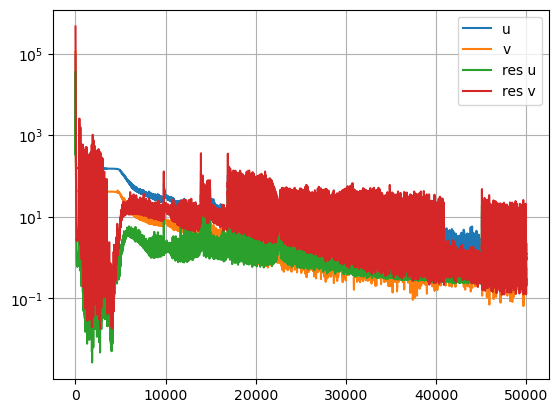

In [17]:
plt.plot(losses2[:, 0], label='u')
plt.plot(losses2[:, 1], label='v')
plt.plot(losses2[:, 2], label='res u')
plt.plot(losses2[:, 3], label='res v')
plt.yscale('log')
plt.grid(); plt.legend(); plt.show()

In [18]:
(u, u_xx, u_yy, u_xy, u_yx, u_t, 
 v, v_xx, v_yy, v_xy, v_yx, v_t) = grads(pinn2, pattern.t_star[-1:].astype(np.float32))

In [38]:
def RMSE(arr1, arr2):
    #return np.sqrt(np.mean(((arr1-arr2)/np.max(arr2))**2))
    return np.sqrt(np.mean(((arr1-arr2)/(arr2 + 1e-20))**2))
                          
print("u: ", RMSE(u, pattern.c[0,:, : , -1]))
print("v: ", RMSE(v, pattern.c[1,:, : , -1]))
print("u_xx: ", RMSE(u_xx, pattern.c_xx[0,:, : , -1]))
print("v_xx: ", RMSE(v_xx, pattern.c_xx[1,:, : , -1]))
print("u_yy: ", RMSE(u_yy, pattern.c_yy[0,:, : , -1]))
print("v_yy: ", RMSE(v_yy, pattern.c_yy[1,:, : , -1]))
print("u_t: ", RMSE(u_t, pattern.c_t[0,:, : , -1]))
print("v_t: ", RMSE(v_t, pattern.c_t[1,:, : , -1]))

u:  0.0036257673
v:  0.0024991876
u_xx:  3.751177
v_xx:  2.5170083
u_yy:  6.481756
v_yy:  5.036401
u_t:  2.5583458
v_t:  5.656528


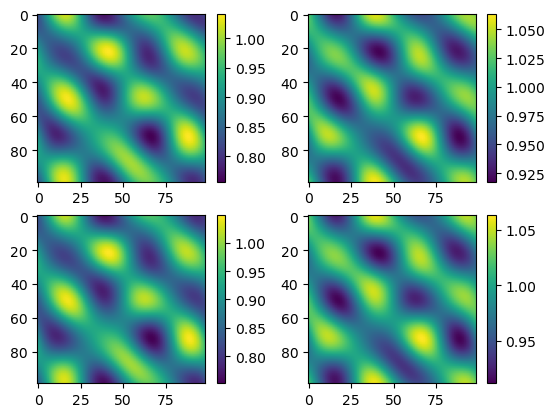

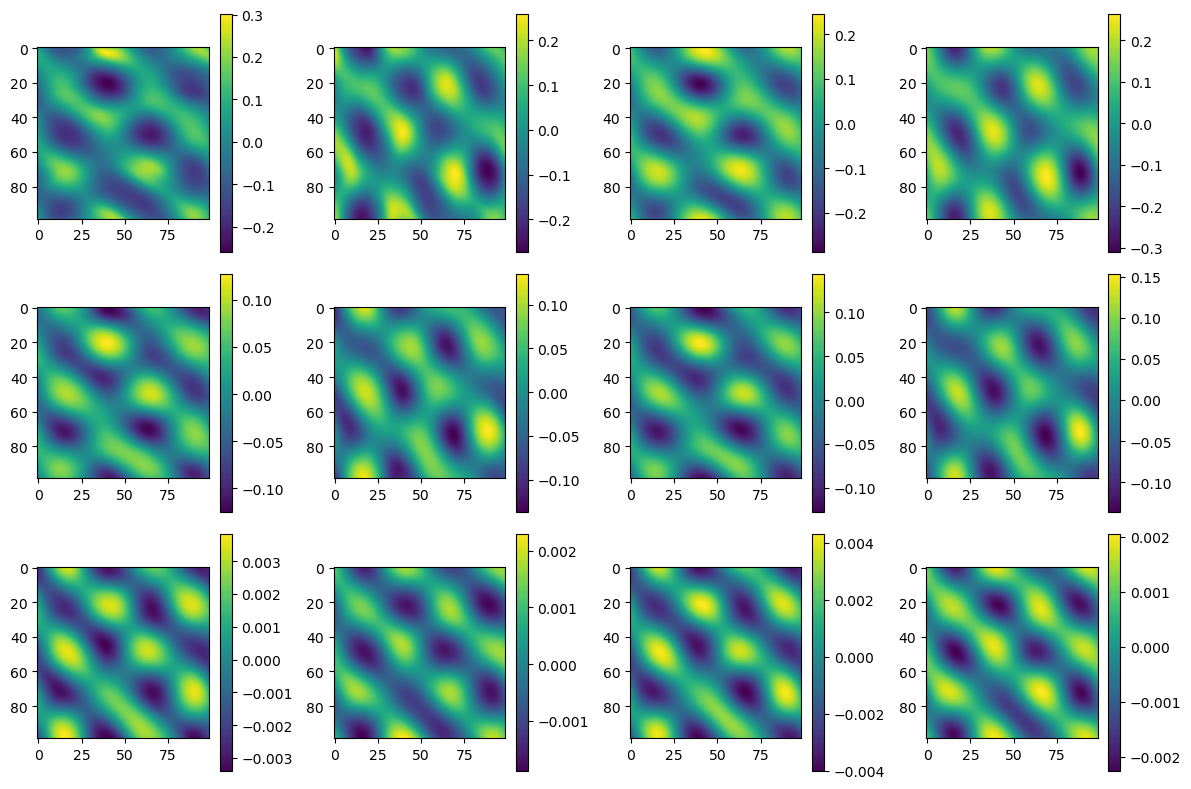

In [20]:
plt.subplot(221)
plt.imshow(u)
plt.colorbar()
plt.subplot(222)
plt.imshow(v)
plt.colorbar()
plt.subplot(223)
plt.imshow(pattern.c[0,:,:,-1])
plt.colorbar()
plt.subplot(224)
plt.imshow(pattern.c[1,:,:,-1])
plt.colorbar()
plt.show()

plt.figure(figsize=(12, 8))
plt.subplot(341)
plt.imshow(u_xx)
plt.colorbar()
plt.subplot(342)
plt.imshow(u_yy)
plt.colorbar()
plt.subplot(343)
plt.imshow(pattern.c_xx[0,:, : , -1])
plt.colorbar()
plt.subplot(344)
plt.imshow(pattern.c_yy[0,:, : , -1])
plt.colorbar()
plt.subplot(345)
plt.imshow(v_xx)
plt.colorbar()
plt.subplot(346)
plt.imshow(v_yy)
plt.colorbar()
plt.subplot(347)
plt.imshow(pattern.c_xx[1,:, : , -1])
plt.colorbar()
plt.subplot(3,4,8)
plt.imshow(pattern.c_yy[1,:, : , -1])
plt.colorbar()
plt.tight_layout()
plt.subplot(3,4,9)
plt.imshow(u_t)
plt.colorbar()
plt.subplot(3,4,10)
plt.imshow(v_t)
plt.colorbar()
plt.subplot(3,4,11)
plt.imshow(pattern.c_t[0,:, : , -1])
plt.colorbar()
plt.subplot(3,4,12)
plt.imshow(pattern.c_t[1,:, : , -1])
plt.colorbar()
plt.tight_layout()
plt.show()

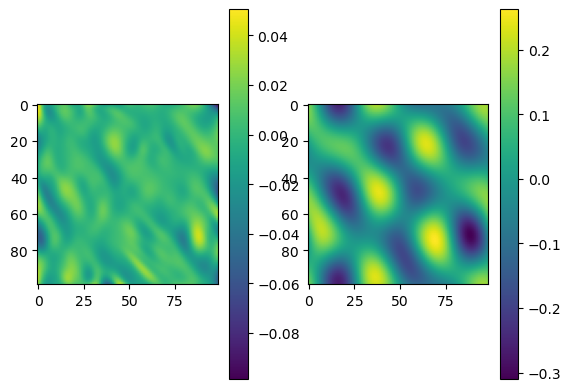

In [35]:
plt.subplot(121)
plt.imshow(u_yy - pattern.c_yy[0,:, : , -1])
plt.colorbar()
plt.subplot(122)
plt.imshow(pattern.c_yy[0,:, : , -1])
plt.colorbar()

In [39]:
from scipy.optimize import lsq_linear
from scipy import linalg

u_vec_ac = np.array([pattern.params["rho_u"], pattern.params["mu_u"],
                     pattern.params["sigma_u"], pattern.params["kappa_u"]])

u_vec    = np.array([rho_u.numpy(), mu_u.numpy(), sigma_u.numpy(), kappa_u.numpy()])

v_vec_ac = np.array([pattern.params["rho_v"], 
                     pattern.params["sigma_v"], pattern.params["kappa_u"]])

v_vec    = np.array([rho_v.numpy(), sigma_v.numpy(), kappa_u.numpy()])

params2 = np.concatenate([u_vec[:-1], v_vec[:-1]])
params3 = np.concatenate([u_vec_ac[:-1], v_vec_ac[:-1]])

u_sol = u.numpy().flatten()
v_sol = v.numpy().flatten()
n2 = u_sol.shape[0]
kappa_sol = kappa_u.numpy()#pde_resKM.kappa_u.get_value(0).numpy()[0]

f_sol = u_sol * u_sol * v_sol / (1.0 + kappa_sol * u_sol * u_sol)


uxxyy_sol = D_u.numpy()*(u_xx.numpy() + u_yy.numpy()).flatten()
vxxyy_sol = D_v.numpy()*(v_xx.numpy() + v_yy.numpy()).flatten()

A_sol =  np.vstack((np.c_[f_sol,  u_sol,  [1]*n2, [0]*n2, [0]*n2],
                    np.c_[[0]*n2, [0]*n2, [0]*n2,-f_sol,  [1]*n2]))


u_dt_sol = (u_t.numpy()).flatten()
v_dt_sol = (v_t.numpy()).flatten()

b_sol =  np.r_[(u_dt_sol-uxxyy_sol, v_dt_sol-vxxyy_sol)]

In [40]:
np.sqrt(np.mean(((np.dot(A_sol, params2)-b_sol))**2))

2.1033052294223378

In [41]:
np.sqrt(np.mean(((np.dot(A_sol, params3)-b_sol))**2))

1.187701357748439